In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [15]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

In [16]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

In [17]:
!ls

'2022-06-13 16:51:51.533596.jpg'   keypoint_pickup.py   output_class.mp4
'2022-06-14 16:54:42.282751.jpg'   LICENSE	        pipelines
 angle_line.py			   mobilenet.pt         __pycache__
 classifier.ipynb		   model_mob.onnx       pytorch.ipynb
 common				   model.onnx	        README.md
 crop_image			   model.tflite         resnet.pth
 docs				   monitors.py	        tmp_model
 examples			   mymodel	        transfer_model.h5
 helpers.py			   mymodel_mobilenet    Untitled.ipynb
 html_reader.py			   openvino_models      urtils.py
 human-pose-estimation-0001	   openvino_pose.py     yolov5m.pt
 keypoint_classifier.py		   output9.mp4


In [18]:
data_dir = 'crop_image/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(class_names)

['item', 'no_item']


In [19]:
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()

In [20]:
image_datasets["train"].find_classes

<bound method DatasetFolder.find_classes of Dataset ImageFolder
    Number of datapoints: 3883
    Root location: crop_image/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.5 0.5 0.5], std=[0.25 0.25 0.25])
           )>

In [21]:
inputs, classes = next(iter(dataloaders['train']))

In [22]:
out = torchvision.utils.make_grid(inputs)

In [23]:
out.shape

torch.Size([3, 228, 906])

In [24]:
inputs.shape

torch.Size([4, 3, 224, 224])

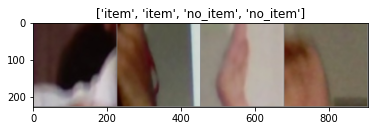

In [25]:
imshow(out, title=[class_names[x] for x in classes])

In [33]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [26]:
model_conv = torchvision.models.resnet18(pretrained=False)

In [54]:
for name, child in model_conv.named_children():
    print(name,child)

features Sequential(
  (0): ConvNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU6(inplace=True)
  )
  (1): InvertedResidual(
    (conv): Sequential(
      (0): ConvNormActivation(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (2): InvertedResidual(
    (conv): Sequential(
      (0): ConvNormActivation(
        (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

In [28]:
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

In [29]:
model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

In [30]:
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

In [31]:
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [34]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=50)

Epoch 0/49
----------
train Loss: 0.6784 Acc: 0.6392
val Loss: 0.9691 Acc: 0.5393

Epoch 1/49
----------
train Loss: 0.6397 Acc: 0.6727
val Loss: 0.3967 Acc: 0.8449

Epoch 2/49
----------
train Loss: 0.6182 Acc: 0.6755
val Loss: 0.3237 Acc: 0.8831

Epoch 3/49
----------
train Loss: 0.6378 Acc: 0.6819
val Loss: 0.4801 Acc: 0.6831

Epoch 4/49
----------
train Loss: 0.5944 Acc: 0.7044
val Loss: 0.3099 Acc: 0.8921

Epoch 5/49
----------
train Loss: 0.6249 Acc: 0.6959
val Loss: 0.3116 Acc: 0.8787

Epoch 6/49
----------
train Loss: 0.6034 Acc: 0.7077
val Loss: 0.2978 Acc: 0.9169

Epoch 7/49
----------
train Loss: 0.5030 Acc: 0.7515
val Loss: 0.3467 Acc: 0.8652

Epoch 8/49
----------
train Loss: 0.5136 Acc: 0.7404
val Loss: 0.2934 Acc: 0.9213

Epoch 9/49
----------
train Loss: 0.5008 Acc: 0.7502
val Loss: 0.2794 Acc: 0.9034

Epoch 10/49
----------
train Loss: 0.5047 Acc: 0.7453
val Loss: 0.3551 Acc: 0.8629

Epoch 11/49
----------
train Loss: 0.5056 Acc: 0.7407
val Loss: 0.2868 Acc: 0.8899

Ep

In [35]:
torch.save(model_conv,"resnet_full.pth")

In [104]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_handeled = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_handeled += 1
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [2]:
model = torch.load("mobilenet.pt")

In [5]:
preprocess=transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

In [6]:
from PIL import Image
import cv2

In [7]:
input_image = cv2.imread("crop_image/val/item/2022-06-13 16:54:05.995029.jpg")

In [8]:
topil=transforms.ToPILImage()
input_image = topil(input_image)

In [9]:
input_tensor = preprocess(input_image)

In [10]:
input_batch = input_tensor.unsqueeze(0)

In [11]:
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

In [12]:
with torch.no_grad():
    output = model(input_batch)

RuntimeError: Given groups=1, weight of size [32, 3, 3, 3], expected input[1, 224, 4, 225] to have 3 channels, but got 224 channels instead

In [13]:
input_batch.shape

torch.Size([1, 3, 224, 224])

In [115]:
probabilities = torch.nn.functional.softmax(output[0], dim=0)
print(np.argmax(probabilities.cpu().numpy()))

0


In [4]:
test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                     ])

In [14]:
device = "cuda"

In [16]:
def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    print(input.shape)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

In [12]:
import cv2
from torch.autograd import Variable

In [7]:
img = cv2.imread("2022-06-13 16:51:51.533596.jpg")

In [9]:
topil=transforms.ToPILImage()

In [10]:
img = topil(img)

In [1]:
from openvino.inference_engine import IECore

In [11]:
ie= IECore()

net_c = ie.read_network(model="my_16/saved_model.xml",weights="my_16/saved_model.bin")
input_layer_c = next(iter(net_c.inputs))
print(net_c.inputs[input_layer_c].shape)
n_c,c_c,h_c,w_c = net_c.inputs[input_layer_c].shape
output_layer_c = next(iter(net_c.outputs))
exec_net_c = ie.load_network(network=net_c,device_name="CPU",num_requests = 1)

[1, 3, 224, 224]


/home/omkar/anaconda3/envs/openvino/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 'inputs' property of IENetwork class is deprecated. To access DataPtrs user need to use 'input_data' property of InputInfoPtr objects which can be accessed by 'input_info' property.
  after removing the cwd from sys.path.


In [3]:
import cv2

In [24]:
crop = cv2.imread("2022-06-13 16:51:51.533596.jpg")
input_image = cv2.resize(crop, (w_c,h_c))
input_image = input_image.transpose((2,0,1))
input_image.reshape((n_c,c_c,h_c,w_c))
infer_req_ = exec_net_c.start_async(request_id=0,inputs={input_layer_c:input_image})
status=infer_req_.wait()
flag = infer_req_.outputs[output_layer_c]
print(flag)

[[0.942972   0.05702801]]


/home/omkar/anaconda3/envs/openvino/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: 'outputs' property of InferRequest is deprecated. Please instead use 'output_blobs' property.
  import sys
